### 1. Library Import and Data Loading
Importing essential libraries for data analysis and machine learning. The housing dataset is loaded into a pandas DataFrame for inspection.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

dataset = pd.read_csv('train.csv')

print(f"Dataset Shape: {dataset.shape}")
dataset.head()

Dataset Shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### 2. Feature Engineering and Preprocessing
This step involves:
1. **Outlier Removal:** Filtering out large properties with unusually low prices to reduce noise.
2. **Log Transformation:** Applying `log1p` to the target variable (`SalePrice`) to normalize its skewed distribution.
3. **Feature Creation:** Creating a new strong predictor `TotalSF` by combining basement and floor areas.
4. **Encoding:** Converting categorical variables (e.g., Neighborhood) into numeric format using One-Hot Encoding.

In [3]:
dataset = dataset.drop(dataset[(dataset['GrLivArea'] > 4000) & (dataset['SalePrice'] < 300000)].index)

dataset['SalePrice'] = np.log1p(dataset['SalePrice'])

dataset['TotalSF'] = dataset['TotalBsmtSF'] + dataset['1stFlrSF'] + dataset['2ndFlrSF']

selected_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalSF', 'FullBath', 'YearBuilt', 'Neighborhood', 'SalePrice']
dataset_final = dataset[selected_features].copy()

dataset_final = pd.get_dummies(dataset_final, columns=['Neighborhood'], drop_first=True)

dataset_final = dataset_final.fillna(dataset_final.mean())

print("Preprocessing Complete.")

Preprocessing Complete.


### 3. Model Training and Evaluation
We train an **XGBoost Regressor** with optimized hyperparameters.
Predictions are transformed back from the logarithmic scale to the original currency scale to calculate the final **RMSE** and **R² Score**.

------------------------------
Final R² Score: 0.8909
Root Mean Squared Error: $24546.70
------------------------------


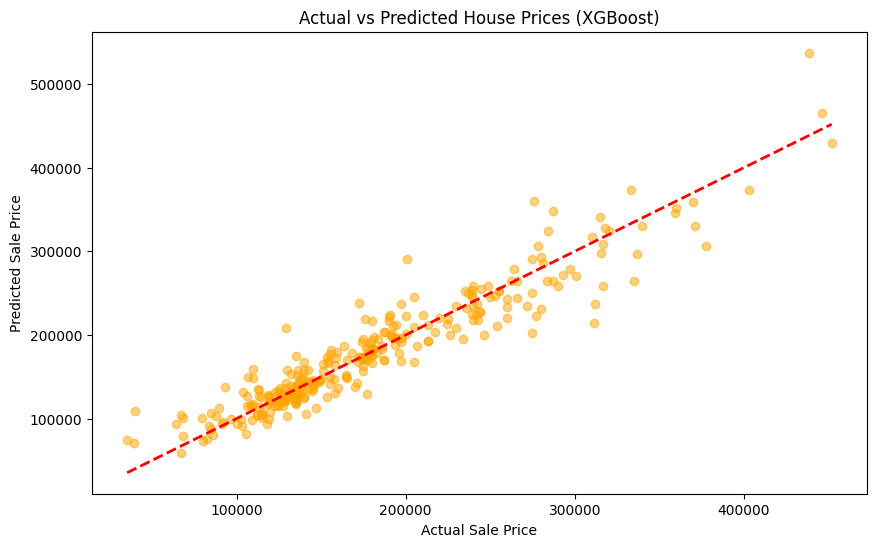

In [4]:
X = dataset_final.drop('SalePrice', axis=1)
y = dataset_final['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = XGBRegressor(
    n_estimators=3000,
    learning_rate=0.01,
    max_depth=4,
    min_child_weight=1.5,
    subsample=0.6,
    colsample_bytree=0.6,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train_scaled, y_train)

y_pred_log = model.predict(X_test_scaled)

y_pred = np.expm1(y_pred_log)
y_test_real = np.expm1(y_test)

r2 = r2_score(y_test_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))

print("-" * 30)
print(f"Final R² Score: {r2:.4f}")
print(f"Root Mean Squared Error: ${rmse:.2f}")
print("-" * 30)

plt.figure(figsize=(10,6))
plt.scatter(y_test_real, y_pred, alpha=0.5, color='orange')
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--', lw=2)
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs Predicted House Prices (XGBoost)")
plt.show()